# Neural Data Science with Python - Day 4 - Notebook A
## Regression, Dimensionality Reduction, Classification and Clustering
* https://www.meetup.com/brain-and-consciousness/events/276875199/
![](images/meetupgroup.png)
* This notebook uses Python 3 (specifically, 3.9)

# Python examples from book: "Neural Data Science" by Erik Nylen and Pascal Wallisch
* https://www.amazon.com/gp/product/B06XCW39WX
* Datasets from book (and Jupyter notebooks for Python 2) at: https://www.elsevier.com/books-and-journals/book-companion/9780128040430/chapter-files#Chapter%20Files
![](images/BookCover.jpg)

# Additional resources
* Open-access neuroscience textbook: https://nba.uth.tmc.edu/neuroscience/s1/introduction.html
* Open-access 3-week computational neuroscience course: https://github.com/NeuromatchAcademy/course-content
    * (Upcoming classes this Summer. Applications for intensive pedagogy due May 7): https://academy.neuromatch.io/
    * New August 2021 course on Deep Learning: https://github.com/NeuromatchAcademy/course-content-dl

# Chapter 7 - Regression

## First toy example: Whole-cell recordings. Correlating subthreshold postsynaptic potentials from some trials with action potentials from other trials.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd    # using pandas to load pickle file in order to avoid ascii error
import pickle

#with open('data\\Psptospikedict.pickle', 'rb') as handle:
#    pspsAndSpikes = pickle.load(handle)
#print(pspsAndSpikes.keys())

pspsAndSpikes = pd.read_pickle('data\\Psptospikedict.pickle')
print(pspsAndSpikes.keys())

dict_keys(['pspTime', 'pspTraces', 'spikeTimesByTrial'])


In [2]:
for key, aRRAy in pspsAndSpikes.items():
    print(key, '\tlength:', len(aRRAy), '\ttype:', type(aRRAy))

pspTime 	length: 800 	type: <class 'numpy.ndarray'>
pspTraces 	length: 100 	type: <class 'list'>
spikeTimesByTrial 	length: 42 	type: <class 'list'>


In [5]:
len(pspsAndSpikes['pspTraces'][0])

800

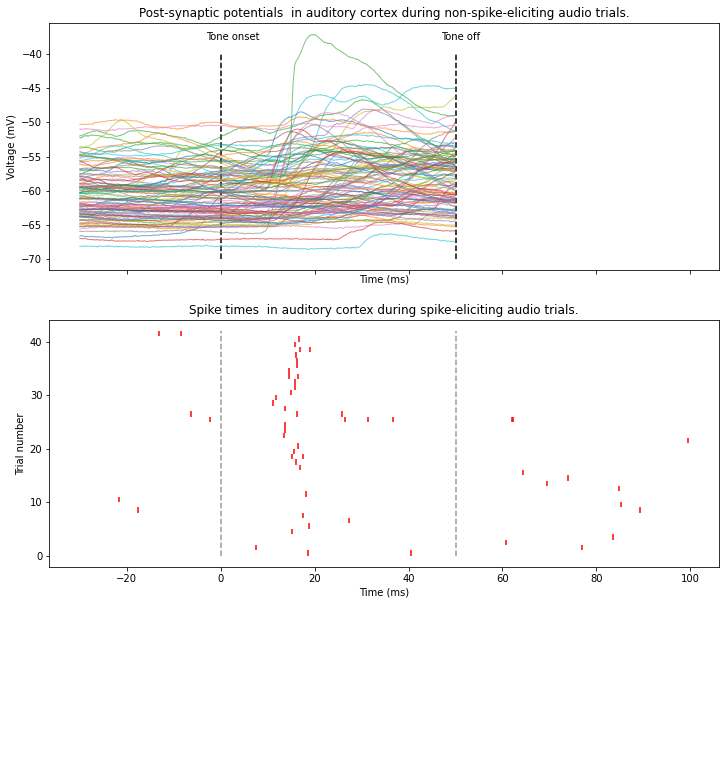

In [91]:
# Plot post-synaptic potentials from subthreshold trials
fig, (ax0, ax1) = plt.subplots(2,1,figsize=(12,10), sharex=True)
for trace in pspsAndSpikes['pspTraces']:
    ax0.plot(pspsAndSpikes['pspTime'], trace, linewidth=1, alpha=0.6)
ax0.set_title('Post-synaptic potentials  in auditory cortex during non-spike-eliciting audio trials.')
ax0.set_ylabel('Voltage (mV)')
ax0.set_xlabel('Time (ms)')

ax0.vlines([0,50], -70, -40, color='k', linestyle='--') # show tone onset and offset
ax0.annotate('Tone onset', (-3, -38))
ax0.annotate('Tone off', (47, -38))

# Plot action potential (spike) times from threshold-reaching trials
for trial_num, spikes in enumerate(pspsAndSpikes['spikeTimesByTrial']):
    #print('Trial '+str(trial_num + 1)+'\t', [np.round(spike,2) for spike in spikes])
    ax1.vlines(spikes, trial_num, trial_num+1, color='r')
ax1.set_xlabel('Time (ms)')
ax1.set_ylabel('Trial number')
ax1.set_title('Spike times  in auditory cortex during spike-eliciting audio trials.')

ax1.vlines([0,50], 0, 42, color='k', linestyle='--', alpha=0.4) # show tone onset and offset
ax1.annotate('Tone onset', (-3, -38))
ax1.annotate('Tone off', (47, -38))

plt.show()

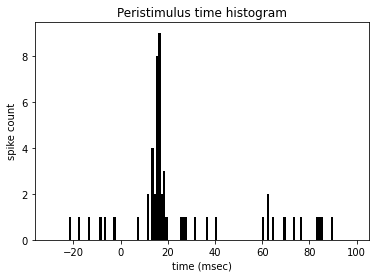

In [34]:
# Let's look at the peri-stimulus time histograms (PSTHs) of the spikes

# Unpack the spikes
spikes = pspsAndSpikes['spikeTimesByTrial'] 
spikesUnpacked = [a for b in spikes for a in b]   # Transfer spikes from list of lists to a single list.

# Define an edges vector that will be used both to parse the spiketrain and serve as a time base later
binrange = np.arange(-30, 100, 1)   # 1-second time bins from -30 sec to +100 sec

# Parse the spike catcher variable by time base
psth, bins, patches = plt.hist(spikesUnpacked, bins=binrange, facecolor='k')  
plt.xlabel('time (msec)')
plt.ylabel('spike count')
plt.title('Peristimulus time histogram')
plt.show()

zeroIndex is 30
fiftyIndex is 80


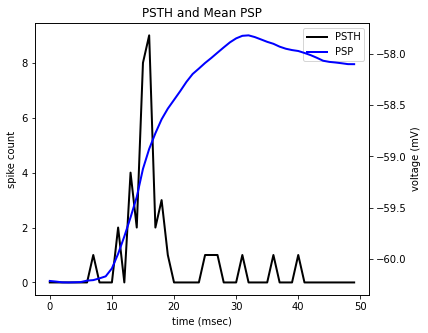

In [90]:
# Let's look at the PSPs as well (post-synaptic potentials)
meanPsp = np.mean(pspsAndSpikes['pspTraces'], 0) # Calculate the mean psp trace

# Downsample the Psp by blending 10 samples together
downSampledPsp = [np.mean(meanPsp[int(ind_ * 10): int(ind_ * 10 + 10)]) for ind_ in range(int(len(meanPsp)/10))]
dPSP = np.diff(downSampledPsp, prepend=0) # Take the point-to-point differential of the mean downsampled PSP # Use prepend

zeroIndex = np.where(binrange==0)[0][0]    # Find index coresponding to time=0
fiftyIndex = np.where(binrange==50)[0][0]  # Find index corresponding to time=50

print('zeroIndex is',zeroIndex)
print('fiftyIndex is',fiftyIndex)

# Make new vectors from snippet in time   
evokedPSTH = psth[zeroIndex: fiftyIndex]   
evokedPSP = downSampledPsp[zeroIndex: fiftyIndex]
evokedDPSP = dPSP[zeroIndex: fiftyIndex]

evokedRange = range(50)                    # New timebase, from 0 to 50

# Now use line plot to plot PSTH as a black line, with PSP as a blue line

f, axarr = plt.subplots(1,1, figsize=(6,5)) 
line1 = axarr.plot(evokedRange, evokedPSTH, c='k', label='PSTH', lw=2)  # Plot PSTH
plt.ylabel('spike count') # left y-axis
plt.xlabel('time (msec)')

ax2 = axarr.twinx()  # Double the y-axis to have 2nd axis on right
line2 = ax2.plot(evokedRange, evokedPSP, c='b', label='PSP', lw=2)   # Plot evoked potential on 2nd y-axis

lines = line1 + line2                        # Hold both lines
lineLabels = [l.get_label() for l in lines]  # Get the line labels
axarr.legend(lines, lineLabels, loc=0, fontsize=10)
plt.ylabel('voltage (mV)')  # 2nd y-axis label (on right)
plt.title('PSTH and Mean PSP')   
plt.show()

# Linear regression:

Regression can be as simple as a line in 2 dimensions (1 predictive dimension or feature (x), 1 target dimension (y)): $$y = m * x + b$$ 

Because models are never expected to have 100% accuracy, there is an error term (epsilon $\epsilon$). Here, $\beta_0$ is the intercept and $\beta_1$ is the slope  $$Y = \beta_0 + \beta_1 X_1 + \epsilon$$ 

Multiple linear regression uses the same formula, where any number of predictive dimensions can be inserted. Each dimension is represented by a $\beta$ coefficient multiplied by data values in the appropriate column $X_i$ 
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \epsilon$$

Interactions between predictive features can be modeled with interaction terms. 
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_1 X_2 + \epsilon$$

##### Notes:

If you choose to include all possible interactions in a model with k features, you will end up with $2^k$ terms (not including error).  
The line in two dimensions has one feature, therefore $2^1=2$ terms.
The three-dimensional example with two features and one interaction has $2^2=4$ terms.
Using 4 predictive features with all interactions would give $2^4=16$ terms.

Linear models are essentially additive models. There is an overall assumption of independence between variables, but interaction terms allow some wiggle room in this assumption. 

Linear models are very amenable to dimensionality transformations and easy to work with using linear algebra and calculus. 

Linear models serve as the basis for many advanced techniques (e.g. SARIMAX), and many other types of models have linear structure embedded within the math (e.g. Logistic Regression, Eigenvectors and PCA).

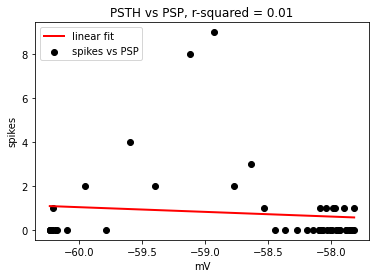

In [59]:
import scipy.stats as st

# Perform linear regression between PSP and PSTH
slope1, intercept1, rvalue1, pvalue1, stderr1 = st.linregress(evokedPSP, evokedPSTH)

PSPrange = np.linspace(min(evokedPSP), max(evokedPSP), 100)  # Create linear space in range of PSP
plt.plot(PSPrange, slope1 * PSPrange + intercept1, c='r', lw=2, label='linear fit')  # plot the regression-fit line
plt.scatter(evokedPSP, evokedPSTH, c='k', label='spikes vs PSP')  # scatter plot the PSTH vs the PSP

plt.title('PSTH vs PSP, r-squared = '+str(rvalue1**2)[:4])  # Report the R-squared value in the title
plt.legend(loc='upper left')
plt.xlabel('mV')
plt.ylabel('spikes')
plt.show()

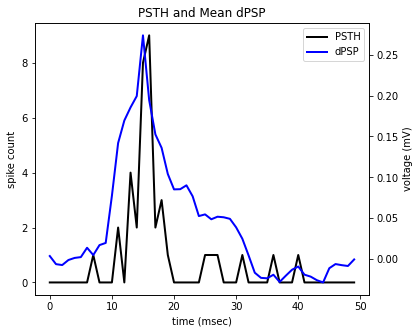

In [60]:
# That regression is terrible. Perhaps it would be better to predict spikes with the moment-to-moment change in PSP (dPSP)

f, axarr = plt.subplots(1,1,figsize=(6,5))
line1 = axarr.plot(evokedRange, evokedPSTH, c='k', label='PSTH', lw=2)  # Plot PSTH
plt.ylabel('spike count')
plt.xlabel('time (msec)')

ax2 = axarr.twinx()   # set up 2nd y-axis on right
line2 = ax2.plot(evokedRange, evokedDPSP, c='b', label='dPSP', lw=2)  # Plot evoked dPSP with 2nd y-axis

lines = line1 + line2  # Hold both lines
lineLabels = [l.get_label() for l in lines]
axarr.legend(lines, lineLabels, loc=0, fontsize=10)
plt.ylabel('voltage (mV)')
plt.title('PSTH and Mean dPSP')
plt.show()

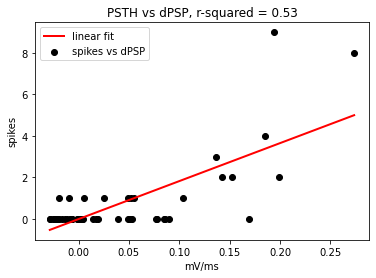

In [61]:
# Now perform regression on dPSP model

slope2, intercept2, rvalue2, pvalue2, stderr2 = st.linregress(evokedDPSP, evokedPSTH) 
dPSPrange = np.linspace(min(evokedDPSP), max(evokedDPSP), 100)
plt.plot(dPSPrange, slope2 * dPSPrange + intercept2, c='r', lw=2, label='linear fit')
plt.scatter(evokedDPSP, evokedPSTH, c='k', label='spikes vs dPSP')
plt.title('PSTH vs dPSP, r-squared = '+str(rvalue2**2)[:4])
plt.xlabel('mV/ms')
plt.ylabel('spikes')
plt.legend(loc='upper left')
plt.show()

## Comparison
<img src="images/first4plots.png" alt="drawing" width="600"/>

In [87]:
# Perhaps exponential fit would be better   (y = a * b**x)

from scipy.optimize import curve_fit

exponential_function = lambda X, a, b: a * b**X  # input data is first argument
popt, pcov = curve_fit(exponential_function, evokedDPSP, evokedPSTH)
print('parameters:',popt)

parameters: [2.99571912e-01 2.40481447e+05]


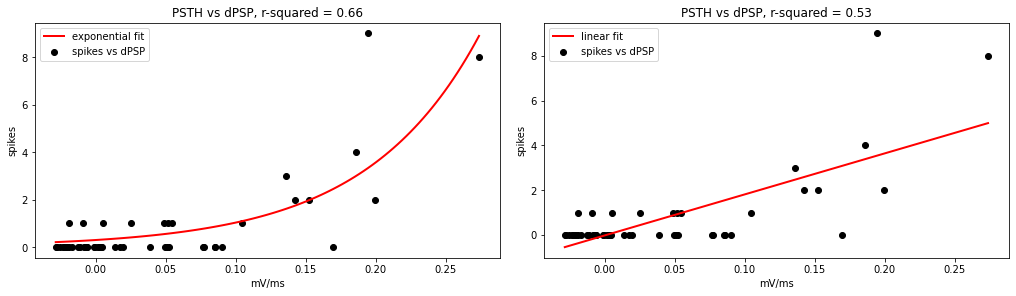

In [85]:
fig, (ax0, ax1) = plt.subplots(1,2,figsize=(14,4), constrained_layout=True)

ax0.plot(dPSPrange, popt[0] * popt[1]**dPSPrange, c='r', lw=2, label='exponential fit')
ax0.scatter(evokedDPSP, evokedPSTH, c='k', label='spikes vs dPSP')

# manually calculate R-squared = 1 - RSS/TSS 
RSS_EXP = np.sum((evokedPSTH - popt[0] * popt[1]**evokedDPSP)**2)
TSS =     np.sum((evokedPSTH - np.mean(evokedPSTH))**2)

R_SQUARED_EXP =  1 - RSS_EXP / TSS

ax0.set_title('PSTH vs dPSP, r-squared = '+str(R_SQUARED_EXP)[:4])
ax0.set_xlabel('mV/ms')
ax0.set_ylabel('spikes')
ax0.legend(loc='upper left')


#Now re-do the linear to make sure my calculation is correct
ax1.plot(dPSPrange, slope2 * dPSPrange + intercept2, c='r', lw=2, label='linear fit')
ax1.scatter(evokedDPSP, evokedPSTH, c='k', label='spikes vs dPSP')

# manually calculate R-squared: MSE(model as estimator)/MSE(mean as estimator)
RSS_LIN = np.sum((evokedPSTH - (slope2 * evokedDPSP + intercept2))**2)
R_SQUARED_LIN =  1 - RSS_LIN / TSS

ax1.set_title('PSTH vs dPSP, r-squared = '+str(R_SQUARED_LIN)[:4])
ax1.set_xlabel('mV/ms')
ax1.set_ylabel('spikes')
ax1.legend(loc='upper left')

plt.show()

# Logistic Regression

Logistic Regression works with probabilities. When expressed in a binary fashion, probabilities can be restated as odds.

$$ Odds = \frac{p}{\sim p} = \frac{p}{1-p} $$

Natural log of the odds is the logit function. Notice that we set this part equal to a linear model.

$$ logit(p) = ln(odds) = ln(\frac{p}{1-p}) = \beta_0 + \beta_1 X_1 $$

The inverse of the logit function will output the probability:

$$ logit^{-1}(x) = \frac{1}{1 + e^{-x}} = \frac{e^x}{1+e^x} $$

Here's the algebraic proof for how it looks in practical implementation.

$$ logit(p) = ln(odds) = ln(\frac{p}{1-p}) = \beta_0 + \beta_1 X_1 $$

$$ \frac{p}{1-p} = e^{\beta_0 + \beta_1 X_1} $$

$$ p = e^{\beta_0 + \beta_1 X_1} (1-p) $$

$$ p = e^{\beta_0 + \beta_1 X_1} - e^{\beta_0 + \beta_1 X_1} * p $$

$$ p + e^{\beta_0 + \beta_1 X_1} * p= e^{\beta_0 + \beta_1 X_1} $$

$$ p * (1 + e^{\beta_0 + \beta_1 X_1}) = e^{\beta_0 + \beta_1 X_1} $$

$$ p = \frac{e^{\beta_0 + \beta_1 X_1}}{(1 + e^{\beta_0 + \beta_1 X_1})} $$

### Toy dataset: GRE scores and grad school admission

In [94]:
import h5py
greDATA = []
with h5py.File('data\\logSATAset.mat') as f:
    for key in f.keys():   # Should be only one key
        for vals in f[key]:    # Should have two columns
            greDATA.append(vals)

x_orig = greDATA[0]   # GRE scores
y = greDATA[1]        # admitted to grad school or not
x = x_orig - np.mean(x_orig)   # mean adjust before entering into logistic function

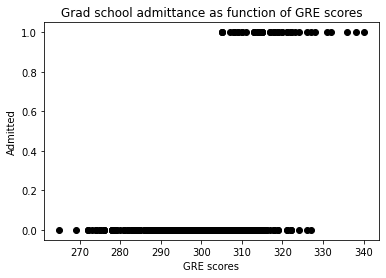

In [95]:
plt.scatter(x_orig, y, c='k')
plt.title('Grad school admittance as function of GRE scores')
plt.xlabel('GRE scores')
plt.ylabel('Admitted')
plt.show()

In [99]:
# Logistic regression from scikit-learn
from sklearn.linear_model import LogisticRegression
logRegression = LogisticRegression()
logRegression.fit(x.reshape(len(x),1), y.reshape(len(y),))   # fit logistic regression with x (scores) and admit status (y)
x_pred = np.arange(x.min(), x.max(), 1)
y_pred = logRegression.predict_proba(x_pred.reshape(len(x_pred),1))  # Return probabilities instead of binary class.
y_proba = np.array([_[1] for _ in y_pred])

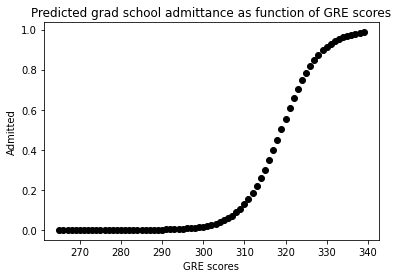

In [100]:
plt.scatter(x_pred + np.mean(x_orig), y_pred[:,1], c='k')
plt.title('Predicted grad school admittance as function of GRE scores')
plt.xlabel('GRE scores')
plt.ylabel('Admitted')
plt.show()

### THE DRESS

![](images\\dress.jpg)

In [170]:
import h5py
dressData = []
with h5py.File("data\\dressDATA.mat", 'r') as f:
    print(list(f.keys()))
    for column in f['DATA']:
        rowData = []
        for rowNumber in range(len(column)):
            try:
                ### The slice of the list comprehension's iterator needed expansion from [:] to [:,0] to work in Python 3.9
                rowData.append(''.join([chr(_) for _ in f[column[rowNumber]][:,0]]))  
            except:
                rowData.append('')
        dressData.append(rowData)
dressData = np.array(dressData).T
numParticipants = len(dressData)
print('numParticipants:',numParticipants)


['#refs#', 'DATA']
numParticipants: 5000


In [171]:
nonResponder = np.zeros(numParticipants) #1
killSet=[];
for nn in range(numParticipants): #3
    if dressData[nn][0]=='': #2
        killSet.append(nn) #4
dressData = [v for i, v in enumerate(dressData) if i not in killSet] # eliminate people who didn't answer question
numParticipants = len(dressData) #6
print('numParticipants:',numParticipants)

numParticipants: 4832


In [172]:
print('{}% of participants kept'.format(100*np.round(numParticipants/5000, 2)))

97.0% of participants kept


In [177]:
print(dressData[0])
print(dressData[1])

['Blue/Gold' "Don't know" '' 'Owl']
['Blue/Black' "Don't know" '' '']


In [174]:
# Data is in form of strings

numResponses = np.zeros(shape=(numParticipants,2))  # This will contain parsed numerical responses
for nn in range(numParticipants): # Loop through all participants
    if dressData[nn][0]=='White/Gold': #Parse the perceptual response of a given participant and assign numerical code
        numResponses[nn][0] = 1 # numerical code
    elif dressData[nn][0]=='Blue/Black': 
        numResponses[nn][0] = 2 # numerical code
    elif dressData[nn][0]=='Blue/Gold': 
        numResponses[nn][0] = 3 # numerical code
    elif dressData[nn][0]=='White/Black': 
        numResponses[nn][0] = 4 # numerical code
    else:
        numResponses[nn][0] = 5 # numerical code for other
    if dressData[nn][3]=='Strong owl': # Parse circadian type and assign numerical code
        numResponses[nn][1] = 1 # numerical code for circadian type
    elif dressData[nn][3]=='Owl': 
        numResponses[nn][1] = 2 # numerical code for circadian type
    elif dressData[nn][3]=='Lark':
        numResponses[nn][1] = 3 # numerical code for circadian type
    elif dressData[nn][3]=='Strong lark': 
        numResponses[nn][1] = 4 # numerical code for circadian type
    else: #3
        numResponses[nn][1] = 5 # numerical code for circadian type

In [175]:
print(numResponses.shape)
print(numResponses[:5,:])

(4832, 2)
[[3. 2.]
 [2. 5.]
 [2. 2.]
 [2. 2.]
 [1. 2.]]


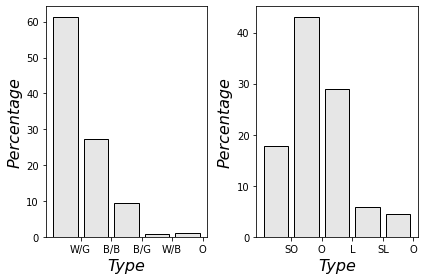

In [178]:
edges = range(int(numResponses.min()),int(numResponses.max())+1) # Define edges vector
edgesplus = range(int(numResponses.min()),int(numResponses.max())+2) #Define edges vector
marginals = []
marginals.append(np.histogram(numResponses[:,0],edgesplus)[0]) #Compute marginals for both kinds of responses, as percentage
marginals.append(np.histogram(numResponses[:,1],edgesplus)[0]) #Compute marginals for both kinds of responses, as percentage
TickLabels = [['W/G','B/B','B/G','W/B','O'],['SO','O','L','SL','O']]
f = plt.figure; 
fsize=16; 
for ii in range(2): 
    ax = plt.subplot(1,2,ii+1); 
     # Bar plot of marginals over edges
    h = plt.bar(edges,marginals[ii]/float(numParticipants)*100,facecolor=[.9,.9,.9], edgecolor='black');
    plt.ylabel('Percentage',fontsize=fsize,style='italic') 
    plt.xlabel('Type',fontsize=fsize,style='italic') 
    plt.xticks([edge+.5 for edge in edges],TickLabels[ii])
plt.tight_layout()
plt.show()

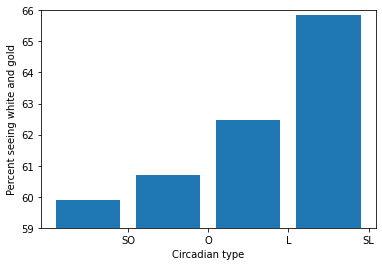

In [180]:
RESULT=np.zeros(4)
for ii in range(4): #4
    temp = np.where(numResponses[:,1]==ii+1) #1
    ColorSubSet = numResponses[temp,0] #2
    RESULT[ii] = len(np.where(ColorSubSet[0]==1)[0])/float(len(ColorSubSet[0]))*100
f = plt.figure() #5
plt.bar(range(4),RESULT) #6
plt.ylim([59, 66]) #7
plt.xlabel('Circadian type') #8
plt.ylabel('Percent seeing white and gold') #8
plt.xticks([edge-.5 for edge in edges[:-1]],TickLabels[1][:-1])
plt.show()

In [227]:
from scipy.stats import spearmanr
correlation_coef, pvalue = spearmanr(numResponses, axis=0)

print('Spearman correlation_coef:', correlation_coef)
print('pvalue:', pvalue)

Spearman correlation_coef: -0.01083628171678668
pvalue: 0.45139870609508514


In [228]:
from scipy.stats import pearsonr
correlation_coef, pvalue = pearsonr(numResponses[:,0], numResponses[:,1])

print('Pearson correlation_coef:', correlation_coef)
print('pvalue:', pvalue)

Pearson correlation_coef: 0.0067203165835347444
pvalue: 0.6404776884201414


[]

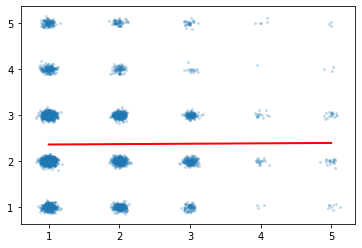

In [226]:
plt.scatter(numResponses[:,0]+np.random.normal(0,0.05,size=len(numResponses[:,0])), numResponses[:,1]+np.random.normal(0,0.05,size=len(numResponses[:,0])), alpha=0.2, s=4)

slope_, intercept_, rvalue_, pvalue_, stderr_ = st.linregress(numResponses[:,0], numResponses[:,1])

Xrange = np.linspace(min(numResponses[:,0]), max(numResponses[:,0]), 100)  # Create linear space in range of PSP
plt.plot(Xrange, slope_ * Xrange + intercept_, c='r', lw=2, label='linear fit')  # plot the regression-fit line
plt.plot()

# Examples of Regression from my own work

I had 2 fluorophores (GFP-conjugated adrenergic receptor and mCherry (i.e. RFP) control) sampled at > 2000Hz. Signal was encoded in sinusoidal waveform with amplitude indicating fluorophore intensity. There was some leakage between channels.

![](images/Figure-fiber-photometry.png)

The amplitude was auto-extracted by the proprietary software, but I wanted to verify its accuracy. Unfortunately, I couldn't find the optimal window parameters. Instead, I used a least squares regression with 20ms of a pure sin wave to fit the scale parameter.

![](images/LSQ_1.png)

This worked beautifully, and it confirmed the auto-extracted signal was trustworthy.

![](images/LSQ_2.png)

## Eventually, I needed to estimate norepinephrine signal. Because the lab rat was awake and behaving, the signal was unstable. I used the SARIMAX framework to build a ARIMAX(0,1,1) model that simultaneously and linearly regressed the differenced GFP's moving average and the control mCherry differenced signal as the exogenous regressor.

![](images/ARIMAX_1.png)
![](images/ARIMAX_2.png)